In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
### Adding root directory to sys.path (list of directories python look in for packages and modules)
import sys, os

root_dir = os.path.abspath("../../..")
sys.path.append( root_dir )

In [5]:
import time
from pathlib import Path
import warnings

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch


from stardist_tools import calculate_extents#, random_label_cmap, relabel_image_stardist3D
from stardist_tools.matching import matching, matching_dataset
from stardist_tools.csbdeep_utils import download_and_extract_zip_file


from src.training import train

from src.data.stardist_dataset import get_dataloader, get_train_val_dataloaders

from utils import seed_all, prepare_conf, plot_img_label2d as plot_img_label

from src.models.config import ConfigBase, Config2D
from src.models.stardist2d import StarDist2D

### Data download

In [6]:
download_and_extract_zip_file(
    url       = 'https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'datasets',
    verbose   = 1,
)

Files found, nothing to download.


### Configuration

In [7]:
print( ConfigBase.__doc__ )


        Configuration for a StarDist model.

        Parameters
        ----------
        data_dir: str or None
            path to data directory with the following structure:
            
            data_dir
                |train
                |----|images
                |----|masks
                |val [Optional]
                |----|images
                |----|masks

            if the `val` directory is absent, the data in the `train` folder will be split.
            
            
        
        patch_size: tuple
            size of image to crop from original images.
        load_epoch: int or 'best' or None
            if not None, will load state corresponding to epoch `load_epoch`
        
        Attributes
        ----------
        name: str
            Name to give to the model
        random_seed: int
            random seed to use for reproducibility

        log_dir: str
            directory path where to save the logs
        checkpoint_dir: str
          

In [8]:
conf = Config2D(
    name                           = 'dsb2018_fluo',
    random_seed                    = 42,
    
    # ========================= dataset ==================================

    data_dir                       = r'datasets\dsb2018',
    val_size                       = 0.15,
    n_rays                         = 32,
    foreground_prob                = 0.9,
    n_classes                      = None, # non null value (multiclass) not supported yet,
    patch_size                     = [256, 256],
    cache_sample_ind               = True,
    cache_data                     = True,

    batch_size                     = 4,
    num_workers                    = 0, #4,

    preprocess                     = "flip_randintensity",
    preprocess_val                 = "none",
    intensity_factor_range         = [0.6, 2.],
    intensity_bias_range           = [-0.2, 0.2],

    #======================================================================
    
    
    # ========================= Networks configurations ==================
    n_channel_in                   = 1,
    resnet_n_blocks                = 4,
    #======================================================================

    
    # ========================= Training ==================================

    use_gpu                        = True if torch.cuda.is_available() else None,
    use_amp                        = False,
    isTrain                        = True ,
    evaluate                       = True,
    #gpu_ids                       = [0]
    #continue_train                = False


    load_epoch                     = None,
    n_epochs                       = 400,
    n_steps_per_epoch              = 100,

    save_epoch_freq                = 50,
    start_saving_best_after_epoch  = 50,
    
    lambda_prob                    = 1.,
    lambda_dist                    = 0.2,
    lambda_reg                     = 0.0001,
    lambda_prob_class              = 1.,

    #======================================================================


    # ========================= Optimizers ================================
    lr                             = 0.0003, #0.0002,

    lr_policy                      = "plateau",
    lr_plateau_factor              = 0.5,
    lr_plateau_threshold           = 0.0000001,
    lr_plateau_patience            = 40,
    min_lr                         = 1e-6
)

In [9]:
seed_all(conf.random_seed)

[ Using Seed :  42  ]


In [10]:
opt = prepare_conf(conf)


 === Computing extents...


stardist_dataset.py (102): didn't find the validation folder <datasets\dsb2018\val>. Splitting data from datasets\dsb2018\train with val_size=0.15


If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
 === Computing anisotropy...
 === Empirical anisotropy of labeled objects = (1.0294117647058822, 1.0)
 === 'grid' set to (2, 2)



### Initializing/loading model

In [11]:
model = StarDist2D(opt)

initialize network with normal
Network [StarDistResnet] was created. Total number of parameters: 0.5 million. To see the architecture, do print(network).


In [12]:
model.opt.n_epochs

400

In [13]:
fov = np.array( [max(r) for r in model._compute_receptive_field()] )
object_median_size = opt.extents

print("Median object size".ljust(25), ":", object_median_size)
print("Network field of veiw".ljust(25), ":", fov)

if any(object_median_size > fov):
    warnings.warn("WARNING: median object size larger than field of view of the neural network.")

Median object size        : [17.  17.5]
Network field of veiw     : [29 29]


### Loading data

In [14]:
train_dataloader, val_dataloader = get_train_val_dataloaders(opt)
    

total_nb_samples = len( train_dataloader.dataset ) + ( len(val_dataloader.dataset) if val_dataloader is not None else 0 )
nb_samples_train = len(train_dataloader.dataset)
nb_samples_val = total_nb_samples - nb_samples_train

print("Total nb samples: ".ljust(40), total_nb_samples)
print("Train nb samples: ".ljust(40), nb_samples_train)
print("Val nb samples: ".ljust(40), nb_samples_val)

Total nb samples:                        447
Train nb samples:                        380
Val nb samples:                          67


In [15]:
print("Train augmentation".ljust(25), ":",  train_dataloader.dataset.opt.preprocess)
print("Val augmentation".ljust(25), ":", val_dataloader.dataset.opt.preprocess)

Train augmentation        : flip_randintensity
Val augmentation          : none


In [16]:
X, Y = train_dataloader.dataset.get_image_mask(0)

In [17]:
#X.min(), X.max(), Y.dtype

In [18]:
X.shape

(1, 520, 696)

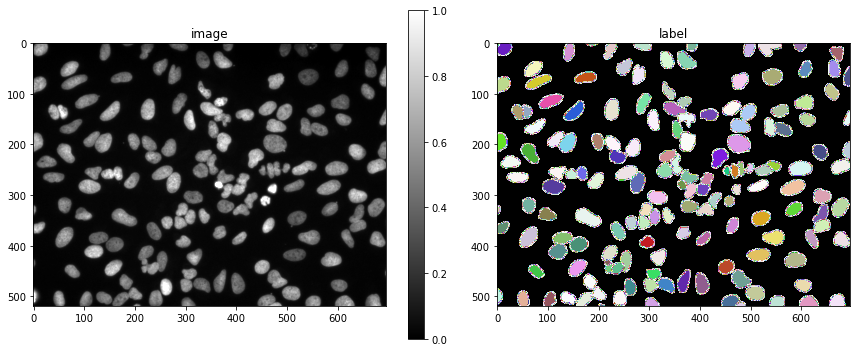

In [19]:
plot_img_label( X[0], Y )

### Data Augmentation

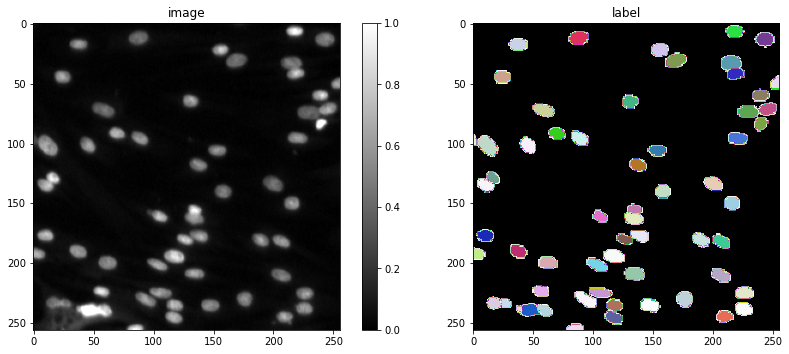

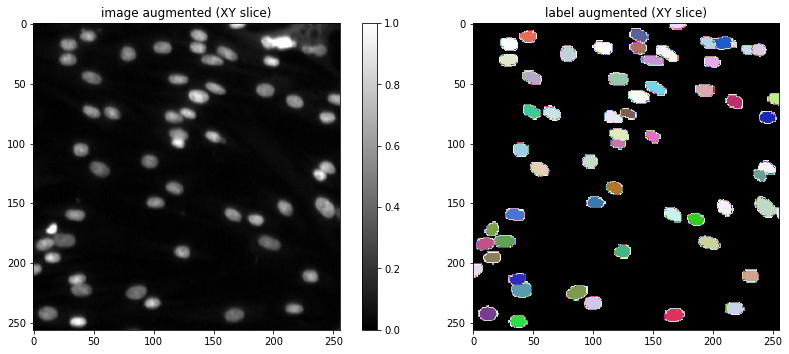

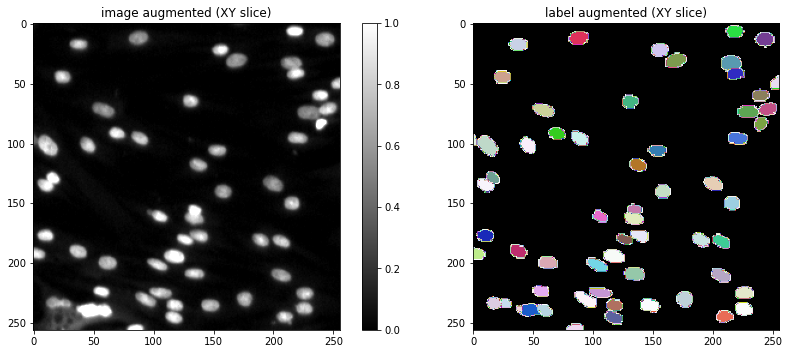

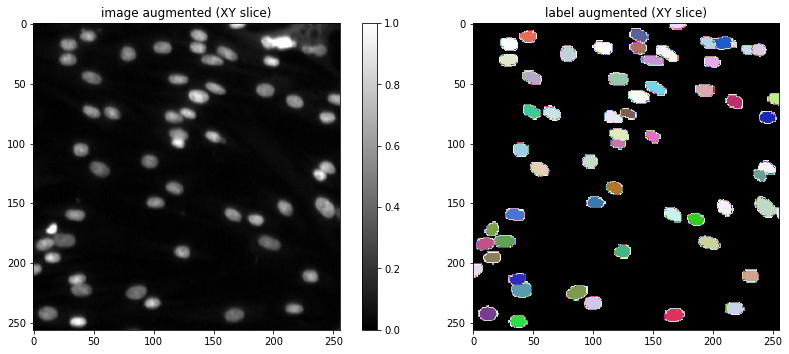

In [20]:
i=1
img, lbl = train_dataloader.dataset.get_image_mask(i, apply_transform=False)
plot_img_label(img[0], lbl)
for _ in range(3):
    img_aug, lbl_aug = train_dataloader.dataset.get_image_mask(i, apply_transform=True)
    plot_img_label(img_aug[0], lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

### Training

In [21]:
%%time
train(model, train_dataloader, val_dataloader)

[Epoch 1/400] [Steps 100/100] [Loss: 2.1866 Loss_dist: 9.0452 Loss_prob: 0.3775 Loss_prob_class: 0.0000] Duration 0:00:25.685755
[Epoch 1/400] [Batch 17/17] [Val_loss: 1.6904 Val_loss_dist: 7.3035 Val_loss_prob: 0.2297 Val_loss_prob_class: 0.0000]  Duration 0:00:03.201192
learning rate 0.0003000 -> 0.0003000
---
The path <logs\dsb2018_fluo\figures> doesn't exists. It will be created!
[Epoch 2/400] [Steps 100/100] [Loss: 1.8882 Loss_dist: 8.0986 Loss_prob: 0.2685 Loss_prob_class: 0.0000] Duration 0:00:10.428905
[Epoch 2/400] [Batch 17/17] [Val_loss: 1.7045 Val_loss_dist: 7.2327 Val_loss_prob: 0.2580 Val_loss_prob_class: 0.0000]  Duration 0:00:01.208778
learning rate 0.0003000 -> 0.0003000
---
[Epoch 3/400] [Steps 100/100] [Loss: 1.5888 Loss_dist: 6.9133 Loss_prob: 0.2061 Loss_prob_class: 0.0000] Duration 0:00:09.339174
[Epoch 3/400] [Batch 17/17] [Val_loss: 1.3757 Val_loss_dist: 6.0772 Val_loss_prob: 0.1603 Val_loss_prob_class: 0.0000]  Duration 0:00:01.111209
learning rate 0.0003000 ->

[Epoch 51/400] [Steps 100/100] [Loss: 0.5435 Loss_dist: 2.2573 Loss_prob: 0.0921 Loss_prob_class: 0.0000] Duration 0:00:09.302786
[Epoch 51/400] [Batch 17/17] [Val_loss: 0.4993 Val_loss_dist: 2.1009 Val_loss_prob: 0.0792 Val_loss_prob_class: 0.0000]  Duration 0:00:01.133016
learning rate 0.0003000 -> 0.0003000
---
[Epoch 52/400] [Steps 100/100] [Loss: 0.5563 Loss_dist: 2.3242 Loss_prob: 0.0915 Loss_prob_class: 0.0000] Duration 0:00:09.153555
[Epoch 52/400] [Batch 17/17] [Val_loss: 0.5305 Val_loss_dist: 2.2360 Val_loss_prob: 0.0833 Val_loss_prob_class: 0.0000]  Duration 0:00:01.100158
learning rate 0.0003000 -> 0.0003000
---
[Epoch 53/400] [Steps 100/100] [Loss: 0.5478 Loss_dist: 2.2924 Loss_prob: 0.0893 Loss_prob_class: 0.0000] Duration 0:00:09.021975
[Epoch 53/400] [Batch 17/17] [Val_loss: 0.5028 Val_loss_dist: 2.0999 Val_loss_prob: 0.0828 Val_loss_prob_class: 0.0000]  Duration 0:00:01.067303
learning rate 0.0003000 -> 0.0003000
---
[Epoch 54/400] [Steps 100/100] [Loss: 0.5545 Loss_di

[Epoch 96/400] [Batch 17/17] [Val_loss: 0.4928 Val_loss_dist: 2.0824 Val_loss_prob: 0.0764 Val_loss_prob_class: 0.0000]  Duration 0:00:01.313416
learning rate 0.0003000 -> 0.0003000
---
[Epoch 97/400] [Steps 100/100] [Loss: 0.4682 Loss_dist: 1.9113 Loss_prob: 0.0859 Loss_prob_class: 0.0000] Duration 0:00:10.356068
[Epoch 97/400] [Batch 17/17] [Val_loss: 0.4234 Val_loss_dist: 1.7236 Val_loss_prob: 0.0787 Val_loss_prob_class: 0.0000]  Duration 0:00:01.427257
learning rate 0.0003000 -> 0.0003000
---
[Epoch 98/400] [Steps 100/100] [Loss: 0.4541 Loss_dist: 1.8456 Loss_prob: 0.0850 Loss_prob_class: 0.0000] Duration 0:00:10.527832
[Epoch 98/400] [Batch 17/17] [Val_loss: 0.4091 Val_loss_dist: 1.6523 Val_loss_prob: 0.0786 Val_loss_prob_class: 0.0000]  Duration 0:00:01.122752
learning rate 0.0003000 -> 0.0003000
---
[Epoch 99/400] [Steps 100/100] [Loss: 0.4649 Loss_dist: 1.8803 Loss_prob: 0.0888 Loss_prob_class: 0.0000] Duration 0:00:10.559002
[Epoch 99/400] [Batch 17/17] [Val_loss: 0.4147 Val_l

[Epoch 143/400] [Steps 100/100] [Loss: 0.4039 Loss_dist: 1.5952 Loss_prob: 0.0849 Loss_prob_class: 0.0000] Duration 0:00:10.853945
[Epoch 143/400] [Batch 17/17] [Val_loss: 0.3728 Val_loss_dist: 1.4702 Val_loss_prob: 0.0788 Val_loss_prob_class: 0.0000]  Duration 0:00:01.396055
learning rate 0.0003000 -> 0.0003000
---
[Epoch 144/400] [Steps 100/100] [Loss: 0.4052 Loss_dist: 1.6069 Loss_prob: 0.0839 Loss_prob_class: 0.0000] Duration 0:00:10.860998
[Epoch 144/400] [Batch 17/17] [Val_loss: 0.3852 Val_loss_dist: 1.5326 Val_loss_prob: 0.0787 Val_loss_prob_class: 0.0000]  Duration 0:00:01.481961
learning rate 0.0003000 -> 0.0003000
---
[Epoch 145/400] [Steps 100/100] [Loss: 0.4131 Loss_dist: 1.6417 Loss_prob: 0.0848 Loss_prob_class: 0.0000] Duration 0:00:11.170129
[Epoch 145/400] [Batch 17/17] [Val_loss: 0.3871 Val_loss_dist: 1.5452 Val_loss_prob: 0.0781 Val_loss_prob_class: 0.0000]  Duration 0:00:01.314048
learning rate 0.0003000 -> 0.0003000
---
[Epoch 146/400] [Steps 100/100] [Loss: 0.4071 

[Epoch 191/400] [Batch 17/17] [Val_loss: 0.3636 Val_loss_dist: 1.4271 Val_loss_prob: 0.0782 Val_loss_prob_class: 0.0000]  Duration 0:00:01.338022
learning rate 0.0003000 -> 0.0003000
---
[Epoch 192/400] [Steps 100/100] [Loss: 0.3844 Loss_dist: 1.5088 Loss_prob: 0.0826 Loss_prob_class: 0.0000] Duration 0:00:10.429571
[Epoch 192/400] [Batch 17/17] [Val_loss: 0.3567 Val_loss_dist: 1.3897 Val_loss_prob: 0.0788 Val_loss_prob_class: 0.0000]  Duration 0:00:01.334959
learning rate 0.0003000 -> 0.0003000
---
[Epoch 193/400] [Steps 100/100] [Loss: 0.3710 Loss_dist: 1.4410 Loss_prob: 0.0828 Loss_prob_class: 0.0000] Duration 0:00:10.614924
[Epoch 193/400] [Batch 17/17] [Val_loss: 0.3583 Val_loss_dist: 1.4099 Val_loss_prob: 0.0763 Val_loss_prob_class: 0.0000]  Duration 0:00:01.299004
learning rate 0.0003000 -> 0.0003000
---
[Epoch 194/400] [Steps 100/100] [Loss: 0.3866 Loss_dist: 1.5087 Loss_prob: 0.0848 Loss_prob_class: 0.0000] Duration 0:00:10.750042
[Epoch 194/400] [Batch 17/17] [Val_loss: 0.359

[Epoch 215/400] [Steps 100/100] [Loss: 0.3772 Loss_dist: 1.4667 Loss_prob: 0.0839 Loss_prob_class: 0.0000] Duration 0:00:10.526042
[Epoch 215/400] [Batch 17/17] [Val_loss: 0.3764 Val_loss_dist: 1.4989 Val_loss_prob: 0.0766 Val_loss_prob_class: 0.0000]  Duration 0:00:01.440978
learning rate 0.0003000 -> 0.0003000
---
[Epoch 216/400] [Steps 100/100] [Loss: 0.3790 Loss_dist: 1.4632 Loss_prob: 0.0864 Loss_prob_class: 0.0000] Duration 0:00:10.281026
[Epoch 216/400] [Batch 17/17] [Val_loss: 0.3563 Val_loss_dist: 1.3828 Val_loss_prob: 0.0798 Val_loss_prob_class: 0.0000]  Duration 0:00:01.556048
learning rate 0.0003000 -> 0.0003000
---
[Epoch 217/400] [Steps 100/100] [Loss: 0.3872 Loss_dist: 1.5152 Loss_prob: 0.0841 Loss_prob_class: 0.0000] Duration 0:00:10.770052
[Epoch 217/400] [Batch 17/17] [Val_loss: 0.3828 Val_loss_dist: 1.5279 Val_loss_prob: 0.0772 Val_loss_prob_class: 0.0000]  Duration 0:00:01.273017
learning rate 0.0003000 -> 0.0003000
---
[Epoch 218/400] [Steps 100/100] [Loss: 0.3780 

[Epoch 263/400] [Batch 17/17] [Val_loss: 0.3640 Val_loss_dist: 1.4292 Val_loss_prob: 0.0782 Val_loss_prob_class: 0.0000]  Duration 0:00:01.382961
learning rate 0.0003000 -> 0.0003000
---
[Epoch 264/400] [Steps 100/100] [Loss: 0.3754 Loss_dist: 1.4535 Loss_prob: 0.0847 Loss_prob_class: 0.0000] Duration 0:00:10.601384
[Epoch 264/400] [Batch 17/17] [Val_loss: 0.3562 Val_loss_dist: 1.4011 Val_loss_prob: 0.0760 Val_loss_prob_class: 0.0000]  Duration 0:00:01.311038
learning rate 0.0003000 -> 0.0003000
---
[Epoch 265/400] [Steps 100/100] [Loss: 0.3786 Loss_dist: 1.4706 Loss_prob: 0.0845 Loss_prob_class: 0.0000] Duration 0:00:11.041115
[Epoch 265/400] [Batch 17/17] [Val_loss: 0.3498 Val_loss_dist: 1.3543 Val_loss_prob: 0.0789 Val_loss_prob_class: 0.0000]  Duration 0:00:01.281035
learning rate 0.0003000 -> 0.0003000
---
[Epoch 266/400] [Steps 100/100] [Loss: 0.3709 Loss_dist: 1.4359 Loss_prob: 0.0837 Loss_prob_class: 0.0000] Duration 0:00:10.977728
[Epoch 266/400] [Batch 17/17] [Val_loss: 0.337

[Epoch 312/400] [Batch 17/17] [Val_loss: 0.3485 Val_loss_dist: 1.3601 Val_loss_prob: 0.0765 Val_loss_prob_class: 0.0000]  Duration 0:00:01.274338
learning rate 0.0001500 -> 0.0001500
---
[Epoch 313/400] [Steps 100/100] [Loss: 0.3572 Loss_dist: 1.3697 Loss_prob: 0.0833 Loss_prob_class: 0.0000] Duration 0:00:10.066744
[Epoch 313/400] [Batch 17/17] [Val_loss: 0.3561 Val_loss_dist: 1.3878 Val_loss_prob: 0.0786 Val_loss_prob_class: 0.0000]  Duration 0:00:01.366265
learning rate 0.0001500 -> 0.0001500
---
[Epoch 314/400] [Steps 100/100] [Loss: 0.3465 Loss_dist: 1.3160 Loss_prob: 0.0833 Loss_prob_class: 0.0000] Duration 0:00:10.503049
[Epoch 314/400] [Batch 17/17] [Val_loss: 0.3353 Val_loss_dist: 1.2935 Val_loss_prob: 0.0767 Val_loss_prob_class: 0.0000]  Duration 0:00:01.474468
learning rate 0.0001500 -> 0.0001500
---
[Epoch 315/400] [Steps 100/100] [Loss: 0.3442 Loss_dist: 1.3142 Loss_prob: 0.0814 Loss_prob_class: 0.0000] Duration 0:00:10.518969
[Epoch 315/400] [Batch 17/17] [Val_loss: 0.327

[Epoch 361/400] [Batch 17/17] [Val_loss: 0.3286 Val_loss_dist: 1.2621 Val_loss_prob: 0.0762 Val_loss_prob_class: 0.0000]  Duration 0:00:01.364834
learning rate 0.0000750 -> 0.0000750
---
[Epoch 362/400] [Steps 100/100] [Loss: 0.3342 Loss_dist: 1.2552 Loss_prob: 0.0831 Loss_prob_class: 0.0000] Duration 0:00:10.509723
[Epoch 362/400] [Batch 17/17] [Val_loss: 0.3336 Val_loss_dist: 1.2861 Val_loss_prob: 0.0764 Val_loss_prob_class: 0.0000]  Duration 0:00:01.395928
learning rate 0.0000750 -> 0.0000750
---
[Epoch 363/400] [Steps 100/100] [Loss: 0.3357 Loss_dist: 1.2694 Loss_prob: 0.0819 Loss_prob_class: 0.0000] Duration 0:00:10.625630
[Epoch 363/400] [Batch 17/17] [Val_loss: 0.3270 Val_loss_dist: 1.2581 Val_loss_prob: 0.0754 Val_loss_prob_class: 0.0000]  Duration 0:00:01.346108
learning rate 0.0000750 -> 0.0000750
---
[Epoch 364/400] [Steps 100/100] [Loss: 0.3326 Loss_dist: 1.2515 Loss_prob: 0.0823 Loss_prob_class: 0.0000] Duration 0:00:09.846639
[Epoch 364/400] [Batch 17/17] [Val_loss: 0.326

### Threshold optimization

In [22]:
conf.load_epoch="best"
best_model = StarDist2D(conf)

Load path: checkpoints\dsb2018_fluo\best.pth cuda:0
Instanciating network
initialize network with normal
Network [StarDistResnet] was created. Total number of parameters: 0.5 million. To see the architecture, do print(network).
<All keys matched successfully>
Optimizers, schedulers and amp_scaler loaded.
Logger loaded.
Loading model from <checkpoints\dsb2018_fluo\best.pth>.



stardist_base.py (467): Didn't find thresholds in checkpoint at <checkpoints\dsb2018_fluo\thresholds.json>. Using Default Thresholds: {'prob': 0.5, 'nms': 0.4}


In [23]:
print( "Best epoch:", best_model.opt.epoch_count )

Best epoch: 393


In [24]:
X, Y = val_dataloader.dataset.get_all_data()
len(X), len(Y)

(67, 67)

In [26]:
%%time
best_model.optimize_thresholds(X, Y)#, predict_kwargs={ "patch_size":(32, 64, 64) } )

NMS threshold = 0.5:  80%|████████████████████████████████████         | 16/20 [00:18<00:04,  1.16s/it, 0.475 -> 0.815]


Using optimized values: prob_thresh=0.473723, nms_thresh=0.3.
Saving to <checkpoints\dsb2018_fluo\thresholds.json>
Wall time: 1min


{'prob': 0.4737231433391571, 'nms': 0.3}

### Evaluation on val set

In [27]:
%%time
Y_pred = [best_model.predict_instance(x)[0] for x in tqdm(X)]

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.18it/s]

Wall time: 3.9 s


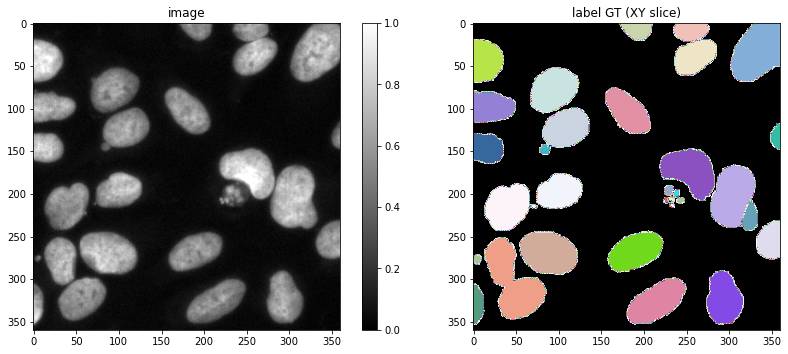

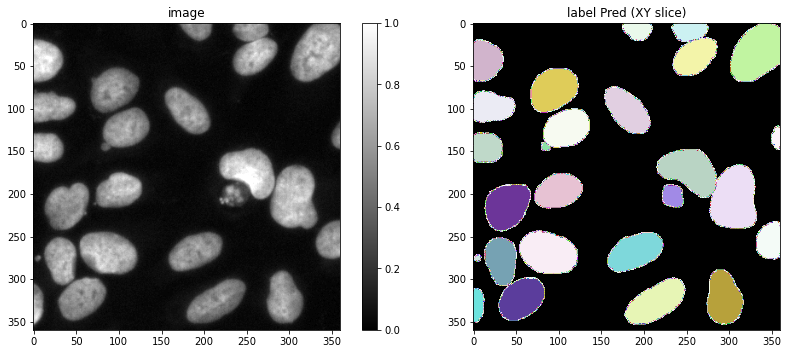

In [28]:
plot_img_label(X[0][0], Y[0], lbl_title="label GT (XY slice)")
plot_img_label(X[0][0], Y_pred[0].astype(np.float32), lbl_title="label Pred (XY slice)")

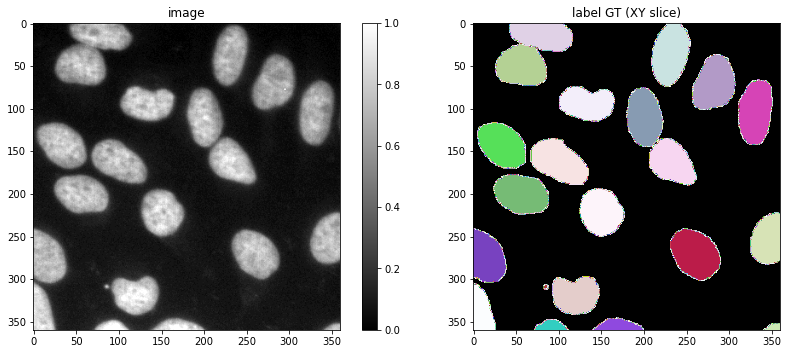

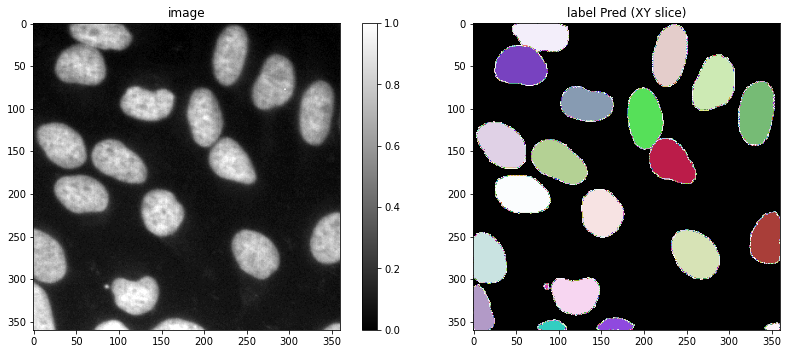

In [29]:
plot_img_label(X[1][0], Y[1], lbl_title="label GT (XY slice)")
plot_img_label(X[1][0], Y_pred[1].astype(np.float32), lbl_title="label Pred (XY slice)")

In [30]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.27it/s]


In [31]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=304, tp=2042, fn=501, precision=0.8704177323103154, recall=0.8029885961462839, accuracy=0.7172462240955392, f1=0.835344651257926, n_true=2543, n_pred=2346, mean_true_score=0.7119545372180286, mean_matched_score=0.8866309442436077, panoptic_quality=0.7406424169136621, by_image=False)

In [32]:
val_acc = []
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    acc = stats[taus.index(t)].accuracy
    val_acc.append(acc)

pd.DataFrame({"threshold": np.array(taus).astype(str), "accuracy": val_acc}).T

,0,1,2,3,4,5,6,7,8
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
accuracy,0.885461,0.884008,0.881108,0.875336,0.853298,0.807394,0.717246,0.572026,0.295443


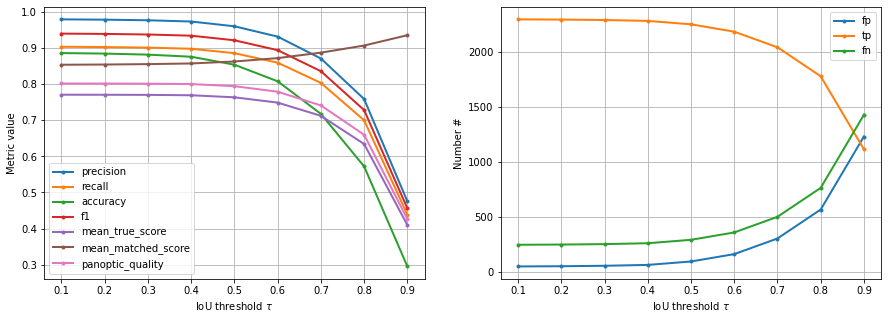

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

### Evaluation on Test

In [34]:
#best_model.thresholds = {'prob': 0.4737694263458252, 'nms': 0.3}

In [35]:
from pathlib import Path

test_dir = Path( opt.data_dir ) / "test"

test_images_dir = test_dir / "images"
test_mask_dir = test_dir / "masks"

test_image_paths = list( Path(test_images_dir).glob("*.tif") )
test_mask_paths = list( Path(test_mask_dir).glob("*.tif") )

len(test_image_paths), len( test_mask_paths )

(50, 50)

In [36]:
from stardist_tools.csbdeep_utils import normalize

In [37]:
from src.data.utils import load_img #, save_img

In [38]:
X = [ normalize( load_img(image_path).squeeze() )[np.newaxis] for image_path in test_image_paths ]
Y = [ load_img(mask_path).squeeze().astype(np.uint32) for mask_path in test_mask_paths  ]

len(X), len(Y)

(50, 50)

In [39]:
%%time
Y_pred = [best_model.predict_instance(x)[0] for x in tqdm(X)]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.80it/s]

Wall time: 3.39 s


In [40]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.08it/s]


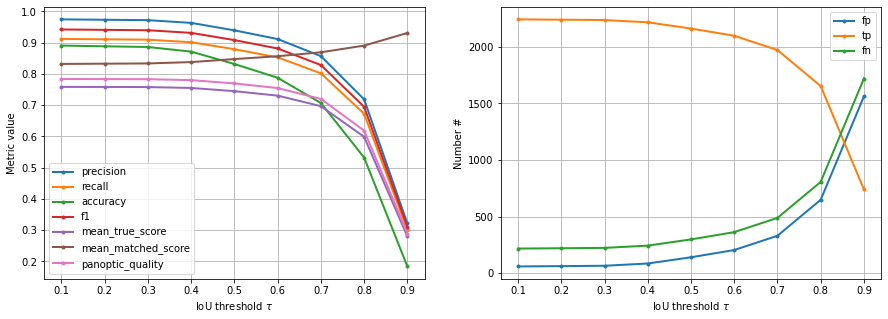

In [41]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [42]:
test_acc = []
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    acc = stats[taus.index(t)].accuracy
    test_acc.append(acc)

pd.DataFrame({"threshold": np.array(taus).astype(str), "accuracy": test_acc}).T

,0,1,2,3,4,5,6,7,8
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
accuracy,0.890433,0.888184,0.885941,0.87112,0.831538,0.787538,0.70681,0.532175,0.183988


### Evaluation on Train

In [44]:
conf.load_epoch="best"
best_model = StarDist2D(conf)

Load path: checkpoints\dsb2018_fluo\best.pth cuda:0
Loading threholds ...
Instanciating network
initialize network with normal
Network [StarDistResnet] was created. Total number of parameters: 0.5 million. To see the architecture, do print(network).
<All keys matched successfully>
Optimizers, schedulers and amp_scaler loaded.
Logger loaded.
Loading model from <checkpoints\dsb2018_fluo\best.pth>.



In [45]:
X, Y = train_dataloader.dataset.get_all_data()
len(X), len(Y)

(380, 380)

In [46]:
%%time
Y_pred = [best_model.predict_instance(x)[0] for x in tqdm(X)]

100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.69it/s]

Wall time: 22.8 s


In [47]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.36s/it]


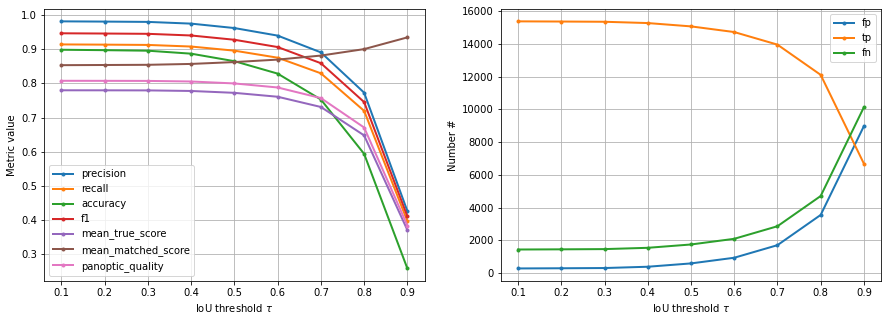

In [48]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [49]:
train_acc = []
for t in np.linspace(0.1, .9, 9):
    t = np.round(t, 1)
    acc = stats[taus.index(t)].accuracy
    train_acc.append(acc)

pd.DataFrame({"threshold": np.array(taus).astype(str), "accuracy": train_acc}).T

,0,1,2,3,4,5,6,7,8
threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
accuracy,0.898359,0.89714,0.89559,0.886895,0.864914,0.828607,0.752859,0.594133,0.259173
